In [ ]:
import pandas as pd
import ast
import numpy as np
import networkx as nx
from random import random

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in individual datasets and create combined dataset
# comment out this code if re-running
num_rows = 10000

data_df = pd.read_csv('/content/drive/MyDrive/Twitch_Dataset/new_graphs_dataset.csv', nrows=num_rows, usecols=['GraphID', 'Nodes', 'Edges'])
labels_df = pd.read_csv('/content/drive/MyDrive/Twitch_Dataset/twitch_egos_graph_labels.txt', nrows=num_rows, header=None)
labels_df = labels_df.rename(columns={0: 'Labels'})

df = pd.concat([data_df, labels_df], axis=1)
df.head()

,GraphID,Nodes,Edges,Labels
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[35, 0], [0, 35], [35, 1], [1, 35], [35, 2], ...",0
1,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[40, 0], [0, 40], [40, 1], [1, 40], [40, 2], ...",0
2,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[31, 0], [0, 31], [31, 1], [1, 31], [31, 2], ...",0
3,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[37, 0], [0, 37], [37, 1], [1, 37], [37, 2], ...",1
4,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[21, 0], [0, 21], [21, 1], [1, 21], [21, 2], ...",0


In [ ]:
num_rows = 1000 # specify the number of rows you want to select for each class
df_0 = df[df['Labels'] == 0].sample(num_rows, random_state=7)
df_1 = df[df['Labels'] == 1].sample(num_rows, random_state=7)
df_balanced = pd.concat([df_0, df_1])

In [ ]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 4254 to 6298
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   GraphID  2000 non-null   int64 
 1   Nodes    2000 non-null   object
 2   Edges    2000 non-null   object
 3   Labels   2000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 78.1+ KB


In [ ]:
# save balanced dataset to csv for use next time
df_balanced.to_csv('/content/balanced_dataset_2000_graphs.csv', index=False)

In [ ]:
# read in balanced dataset for use in classification
df_balanced = pd.read_csv('/content/drive/MyDrive/Twitch_Dataset/balanced_dataset_2000_graphs.csv', usecols=['GraphID', 'Nodes', 'Edges', 'Labels'])
df_balanced

,GraphID,Nodes,Edges,Labels
0,4255,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[43, 0], [0, 43], [43, 1], [1, 43], [43, 2], ...",0
1,343,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[45, 0], [0, 45], [45, 1], [1, 45], [45, 2], ...",0
2,1319,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[43, 0], [0, 43], [43, 1], [1, 43], [43, 2], ...",0
3,2464,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[24, 0], [0, 24], [24, 1], [1, 24], [24, 2], ...",0
4,2068,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[[13, 0], [0, 13], [13, 1], [1, 13], [13, 2], ...",0
...,...,...,...,...
1995,8676,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[18, 0], [0, 18], [18, 1], [1, 18], [18, 2], ...",1
1996,8938,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[41, 0], [0, 41], [41, 1], [1, 41], [41, 2], ...",1
1997,3437,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[27, 0], [0, 27], [27, 1], [1, 27], [27, 2], ...",1
1998,1235,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[23, 0], [0, 23], [23, 1], [1, 23], [23, 2], ...",1


## Using number of nodes, edges and density as features

In [ ]:
import ast

# create a new dataframe to store graph features
graph_features = pd.DataFrame(columns=['num_edges', 'num_nodes', 'density'])

new_rows = []
graph_labels = []

for row in df_balanced.itertuples():
  G = nx.Graph()
  edges = ast.literal_eval(row.Edges)
  nodes = ast.literal_eval(row.Nodes)
  G.add_edges_from(edges)
  G.add_nodes_from(nodes)
  density = nx.density(G)
  new_rows.append({ 'num_edges': len(G.edges()), 'num_nodes': len(G.nodes()), 'density': density})
  graph_labels.append(int(row.Labels))

graph_features = graph_features.append(new_rows)

In [ ]:
#graph_features

,num_edges,num_nodes,density
0,133,44,0.140592
1,323,46,0.312077
2,95,44,0.100423
3,29,25,0.096667
4,13,14,0.142857
...,...,...,...
1995,22,19,0.128655
1996,102,42,0.118467
1997,99,28,0.261905
1998,55,24,0.199275


In [ ]:
# split new dataset into 80-20
Xtrain_data, Xtest_data, ytrain_data, ytest_data = train_test_split(graph_features, graph_labels, test_size=0.2, random_state=42, stratify=graph_labels)

In [ ]:
Xtrain_data

,num_edges,num_nodes,density
1478,283,45,0.285859
1488,161,41,0.196341
499,73,40,0.093590
605,171,51,0.134118
1511,31,21,0.147619
...,...,...,...
1240,27,15,0.257143
452,20,14,0.219780
1248,122,45,0.123232
1303,182,38,0.258890


Accuracy: 64.5%
F1 score: 0.6682242990654205
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       200
           1       0.63      0.71      0.67       200

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.64       400
weighted avg       0.65      0.65      0.64       400

[[115  85]
 [ 57 143]]


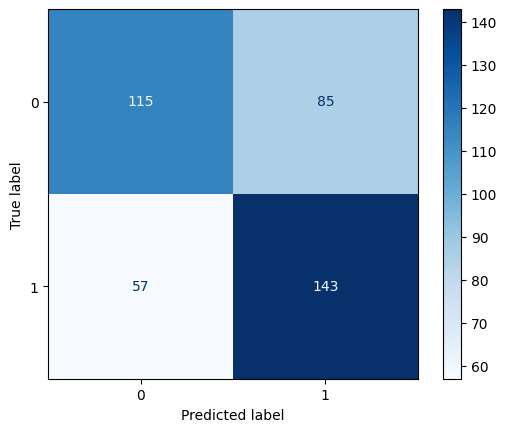

In [ ]:
# Uses the SVM classifier to perform classification
clf_den1 = SVC(kernel="linear")
clf_den1.fit(Xtrain_data, ytrain_data)
ypred_data_den1 = clf_den1.predict(Xtest_data)

# Computes and prints the classification accuracy, f1 scores, confusion matrix
acc = accuracy_score(ytest_data, ypred_data_den1)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(ytest_data, ypred_data_den1))
print(classification_report(ytest_data, ypred_data_den1))
cm = confusion_matrix(ytest_data, ypred_data_den1)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 61.0%
F1 score: 0.6176470588235293
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       200
           1       0.61      0.63      0.62       200

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400

[[118  82]
 [ 74 126]]


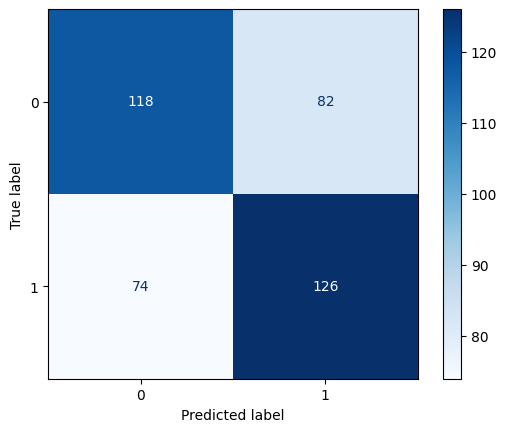

In [ ]:
# use random forest classifier
clf_den2 = RandomForestClassifier(n_estimators=400, n_jobs=-1)

clf_den2.fit(Xtrain_data, ytrain_data)
ypred_data_den2 = clf_den2.predict(Xtest_data)

acc = accuracy_score(ytest_data, ypred_data_den2)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(ytest_data, ypred_data_den2))
print(classification_report(ytest_data, ypred_data_den2))

cm = confusion_matrix(ytest_data, ypred_data_den2)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 64.5%
F1 score: 0.6570048309178744
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       200
           1       0.64      0.68      0.66       200

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.64       400
weighted avg       0.65      0.65      0.64       400

[[122  78]
 [ 64 136]]


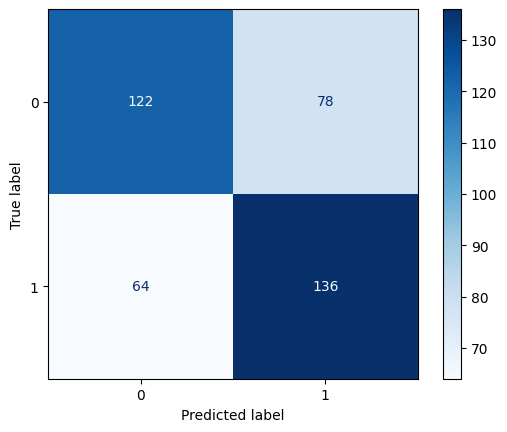

In [ ]:
# use logistic regression for classification
lr = LogisticRegression(random_state=0).fit(Xtrain_data, ytrain_data)
ypred_data_den3 = lr.predict(Xtest_data)
acc = accuracy_score(ytest_data, ypred_data_den3)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(ytest_data, ypred_data_den3))
print(classification_report(ytest_data, ypred_data_den3))
cm = confusion_matrix(ytest_data, ypred_data_den3)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

## Using gklearn Weisfeiler-Lehman kernels

In [ ]:
!pip install graphkit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.9/338.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 76.5 MB/s eta 0:00:00


In [ ]:
from gklearn.kernels import weisfeilerlehmankernel

In [ ]:
# create new graphs list of networkx graphs for use in gklearn
all_graphs = []
graph_labels = []
for row in df_balanced.itertuples():
  edges = ast.literal_eval(row.Edges)
  nodes = ast.literal_eval(row.Nodes)
  new_G = nx.Graph()
  new_G.add_nodes_from(nodes)
  new_G.add_edges_from(edges)
  all_graphs.append(new_G)
  graph_labels.append(int(row.Labels))

In [ ]:
len(all_graphs), len(graph_labels), all_graphs[0]

(2000, 2000, <networkx.classes.graph.Graph at 0x7fe39dec7b50>)

In [ ]:
# create the similarity matrix of weisfeiler lehman kernels
kernel = weisfeilerlehmankernel(all_graphs, height=1)


 --- Weisfeiler-Lehman subtree kernel matrix of size 2000 built in 81.43391394615173 seconds ---


In [ ]:
type(kernel[0])

numpy.ndarray

In [ ]:
# split dataset into 80-20 split
wlx_train, wlx_test, wly_train, wly_test = train_test_split(kernel[0], graph_labels, test_size=0.2, random_state=42, stratify=graph_labels)
wlx_train

array([[2072., 2146., 2069., ..., 1313., 1129., 1269.],
       [1942., 1957., 1956., ..., 1230., 1060., 1196.],
       [2011., 1962., 2063., ..., 1218., 1108., 1255.],
       ...,
       [2164., 2165., 2220., ..., 1380., 1207., 1343.],
       [1745., 1799., 1753., ..., 1120.,  959., 1072.],
       [2261., 2381., 2255., ..., 1439., 1233., 1384.]])

In [ ]:
wlx_train.shape, wlx_test.shape

((1600, 2000), (400, 2000))

In [ ]:
# reshape train and test to exclude similarity with test graphs
wlx_train2 = wlx_train[:, :1600]
wlx_test2 = wlx_test[:, :1600]
wlx_train2.shape, wlx_test2.shape

((1600, 1600), (400, 1600))

In [ ]:
wlx_train2[0]

array([2072., 2146., 2069., ...,  985.,  737.,  899.])

Accuracy: 65.5%
F1 score: 0.6698564593301436
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       200
           1       0.64      0.70      0.67       200

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.65       400
weighted avg       0.66      0.66      0.65       400

[[122  78]
 [ 60 140]]


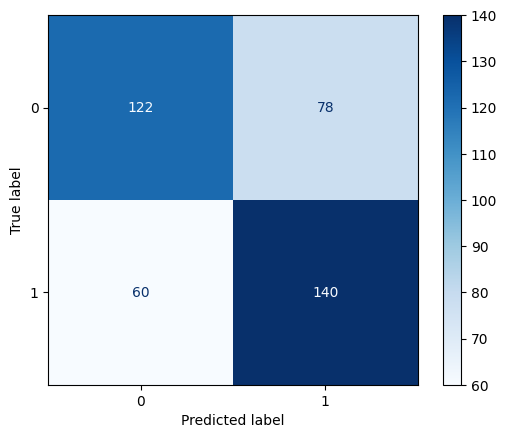

In [ ]:
%matplotlib inline

clf_wl = RandomForestClassifier(n_estimators=400, n_jobs=-1)

clf_wl.fit(wlx_train2, wly_train)
ypred_wl = clf_wl.predict(wlx_test2)

acc = accuracy_score(wly_test, ypred_wl)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(wly_test, ypred_wl))
print(classification_report(wly_test, ypred_wl))
cm = confusion_matrix(wly_test, ypred_wl)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 69.0%
F1 score: 0.7244444444444443
              precision    recall  f1-score   support

           0       0.75      0.56      0.65       200
           1       0.65      0.81      0.72       200

    accuracy                           0.69       400
   macro avg       0.70      0.69      0.69       400
weighted avg       0.70      0.69      0.69       400

[[113  87]
 [ 37 163]]


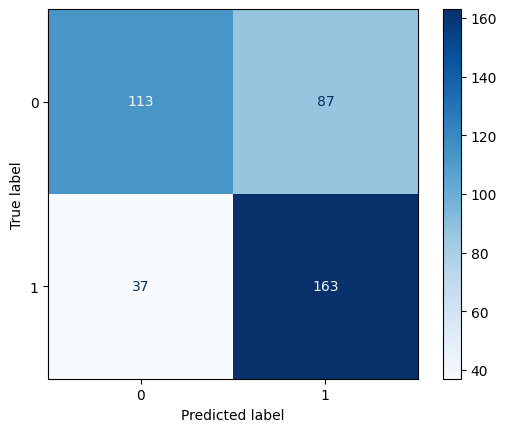

In [ ]:
svc_wl = SVC(kernel="rbf")

svc_wl.fit(wlx_train2, wly_train)
ypred_svc = svc_wl.predict(wlx_test2)

acc = accuracy_score(wly_test, ypred_svc)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(wly_test, ypred_svc))
print(classification_report(wly_test, ypred_svc))
cm = confusion_matrix(wly_test, ypred_svc)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 62.5%
F1 score: 0.5901639344262295
              precision    recall  f1-score   support

           0       0.61      0.71      0.65       200
           1       0.65      0.54      0.59       200

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.63      0.62      0.62       400

[[142  58]
 [ 92 108]]


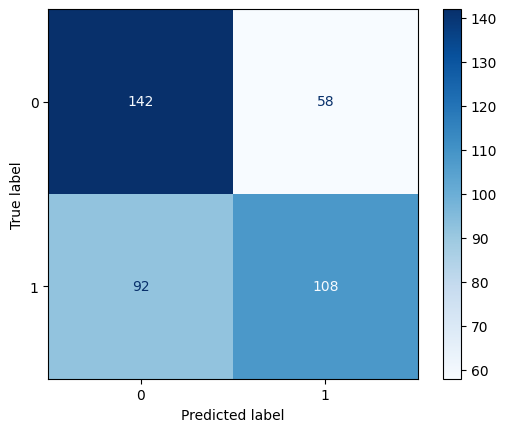

In [ ]:
lr_wl = LogisticRegression(random_state=0, max_iter=500).fit(wlx_train2, wly_train)
ypred_lr = lr_wl.predict(wlx_test2)
acc = accuracy_score(wly_test, ypred_lr)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(wly_test, ypred_lr))
print(classification_report(wly_test, ypred_lr))
cm = confusion_matrix(wly_test, ypred_lr)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

## Using graph embeddings

In [ ]:
!pip install karateclub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from karateclub import FeatherGraph, Graph2Vec

In [ ]:
# create another new graphs list for karateclub
graphs_list_gv = []
y = []
for row in df_balanced.itertuples():
  ls = ast.literal_eval(row.Edges)
  tuple_list = [(x[0], x[1]) for x in ls]
  node_list = ast.literal_eval(row.Nodes)
  dataset1G = nx.Graph()
  dataset1G.add_edges_from(tuple_list)
  dataset1G.add_nodes_from(node_list)
  graphs_list_gv.append(dataset1G)
  y.append(row.Labels)

print(len(graphs_list_gv), len(y))

2000 2000


In [ ]:
# use Feather graph embeddings first
model = FeatherGraph()
model.fit(graphs_list_gv)
X = model.get_embedding()
print(len(X))
len(X[0])

2000


500

In [ ]:
# split into 80-20 train-test
X_train_gv, X_test_gv, y_train_gv, y_test_gv = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 65.5%
F1 score: 0.6515151515151515
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       199
           1       0.66      0.64      0.65       201

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.65       400
weighted avg       0.66      0.66      0.65       400

[[133  66]
 [ 72 129]]


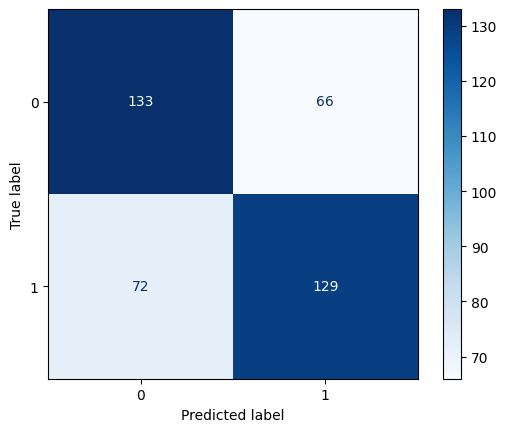

In [ ]:
%matplotlib inline

rf_gv = RandomForestClassifier(n_estimators=400, n_jobs=-1).fit(X_train_gv, y_train_gv)
y_pred_rf_gv = rf_gv.predict(X_test_gv)

acc = accuracy_score(y_test_gv, y_pred_rf_gv)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv, y_pred_rf_gv))
print(classification_report(y_test_gv, y_pred_rf_gv))
cm = confusion_matrix(y_test_gv, y_pred_rf_gv)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 71.75%
F1 score: 0.730310262529833
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       199
           1       0.70      0.76      0.73       201

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400

[[134  65]
 [ 48 153]]


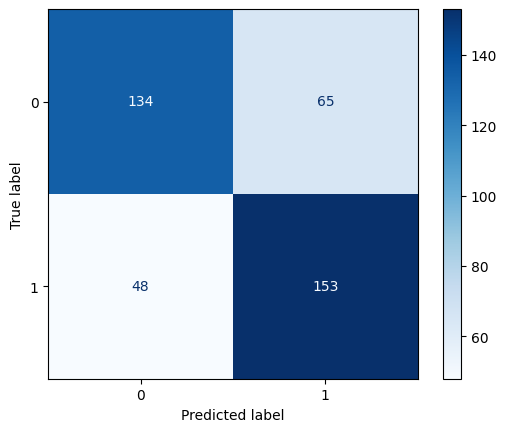

In [ ]:
svc_gv = SVC(kernel="rbf").fit(X_train_gv, y_train_gv)
y_pred_svc_gv = svc_gv.predict(X_test_gv)

acc = accuracy_score(y_test_gv, y_pred_svc_gv)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv, y_pred_svc_gv))
print(classification_report(y_test_gv, y_pred_svc_gv))
cm = confusion_matrix(y_test_gv, y_pred_svc_gv)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 70.25%
F1 score: 0.7104622871046229
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       199
           1       0.70      0.73      0.71       201

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400

[[135  64]
 [ 55 146]]


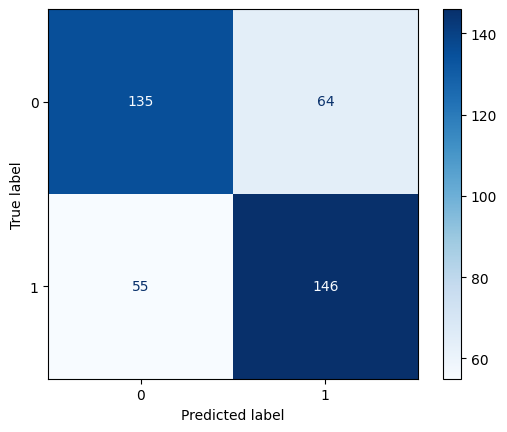

In [ ]:
lr_gv = LogisticRegression(random_state=0, max_iter=500).fit(X_train_gv, y_train_gv)
y_pred_lr_gv = lr_gv.predict(X_test_gv)
acc = accuracy_score(y_test_gv, y_pred_lr_gv)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv, y_pred_lr_gv))
print(classification_report(y_test_gv, y_pred_lr_gv))
cm = confusion_matrix(y_test_gv, y_pred_lr_gv)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# use Graph2Vec embeddings
model2 = Graph2Vec()
model2.fit(graphs_list_gv)
X2 = model2.get_embedding()
print(len(X2))
len(X2[0])

2000


128

In [ ]:
# split into train-test
X_train_gv2, X_test_gv2, y_train_gv2, y_test_gv2 = train_test_split(X2, y, test_size=0.20, random_state=42)

Accuracy: 68.0%
F1 score: 0.6751269035532995
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       199
           1       0.69      0.66      0.68       201

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

[[139  60]
 [ 68 133]]


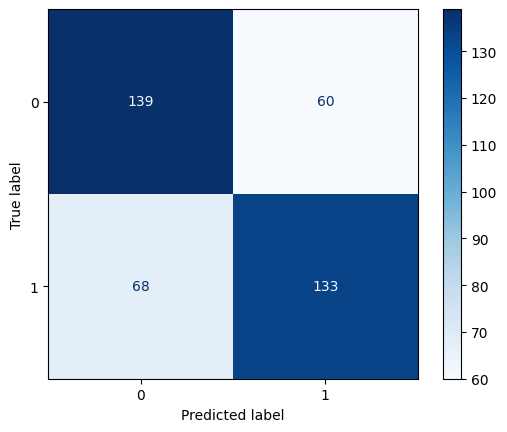

In [ ]:
%matplotlib inline

rf_gv2 = RandomForestClassifier(n_estimators=400, n_jobs=-1).fit(X_train_gv2, y_train_gv2)
y_pred_rf_gv2 = rf_gv2.predict(X_test_gv2)

acc = accuracy_score(y_test_gv2, y_pred_rf_gv2)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv2, y_pred_rf_gv2))
print(classification_report(y_test_gv2, y_pred_rf_gv2))
cm = confusion_matrix(y_test_gv2, y_pred_rf_gv2)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 66.25%
F1 score: 0.6280991735537191
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       199
           1       0.70      0.57      0.63       201

    accuracy                           0.66       400
   macro avg       0.67      0.66      0.66       400
weighted avg       0.67      0.66      0.66       400

[[151  48]
 [ 87 114]]


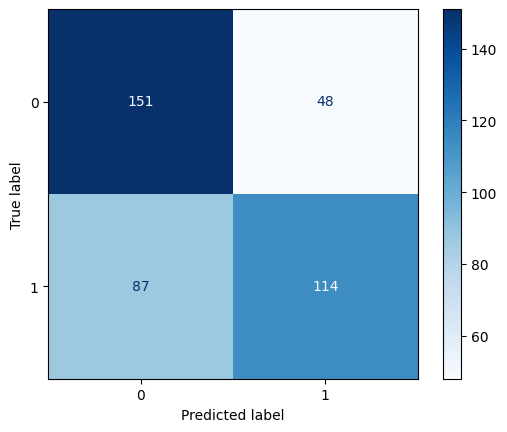

In [ ]:
svc_gv2 = SVC(kernel="rbf").fit(X_train_gv2, y_train_gv2)
y_pred_svc_gv2 = svc_gv2.predict(X_test_gv2)

acc = accuracy_score(y_test_gv2, y_pred_svc_gv2)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv2, y_pred_svc_gv2))
print(classification_report(y_test_gv2, y_pred_svc_gv2))
cm = confusion_matrix(y_test_gv2, y_pred_svc_gv2)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 66.0%
F1 score: 0.6304347826086957
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       199
           1       0.69      0.58      0.63       201

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.67      0.66      0.66       400

[[148  51]
 [ 85 116]]


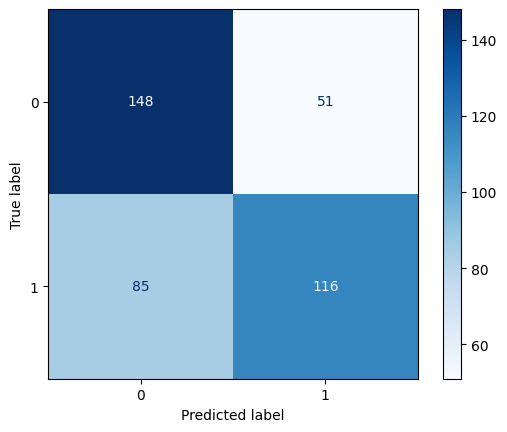

In [ ]:
lr_gv2 = LogisticRegression(random_state=0, max_iter=500).fit(X_train_gv2, y_train_gv2)
y_pred_lr_gv2 = lr_gv2.predict(X_test_gv2)
acc = accuracy_score(y_test_gv2, y_pred_lr_gv2)
print("Accuracy:", str(round(acc*100, 2)) + "%")
print("F1 score:", f1_score(y_test_gv2, y_pred_lr_gv2))
print(classification_report(y_test_gv2, y_pred_lr_gv2))
cm = confusion_matrix(y_test_gv2, y_pred_lr_gv2)
print(cm)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()